# Business Environments of Berlin Neighborhoods – Cluster Analysis #
## Project by Eric Becker as Capstone Project for the IBM Data Science Professional Certification

## 1. Introduction to the Project ##

2020 is a challenging year for starting a business, as the Covid-19 pandemic has reduced demand for most free-time activities as public restrictions limit allowed activities.  These new factors, combined with the preexisting challenges associated with opening a business, make it necessary that a business’s product or service is appropriately matched to the demographics and consumer preferences in its operational location.  This project aims to support entrepreneurs by giving them a clearer understanding of the business environments for each district and neighborhood through clustering at the district and neighborhood levels according to the most popular business categories in each district.  Cluster analysis of available data (described below) will allow entrepreneurs to select the appropriate location for their business to ensure it is suited to local tastes to increase chances of success.

**Question:** Which types of businesses/venues appear to be most common at the district and neighborhood levels throughout the city of Berlin?

## 2. Introduction to the Data ##

### 2.1 Overview of Datasets ###
* **[Foursquare Places API](https://developer.foursquare.com/places) Venue Data:** This API grants developers free access to a massive set of crowdsourced business listing and locational data.  Foursquare powers location data for popular Apps such as Uber, Snapchat, Twitter, AppleMaps, and many more.  Through gathering data on listed businesses in each Berlin district and neighborhood through calls to the Foursquare API, business data can be analyzed to provide insights into the district- and neighborhood-level business environments throughout the city of Berlin. 

* **[Berlin Open Data Portal](https://daten.berlin.de/datensaetze) Datasets:** The Berlin government publishes and updates open source datasets covering a wide range of aspects to aid public and private analysis on trends and developments in the city.
    * **[Registered Residents in Berlin Districts on 31/12/2019](https://www.statistik-berlin-brandenburg.de/opendata/EWR_Ortsteile_2019-12-31.csv) Dataset –** the most recent update to this dataset which contains the number of residents broken down by age groups and at the district and neighborhood levels.

* **The Open Data Information Agency of the Technology Foundation Berlin's [Foundational Geodatasets of Berlin](https://daten.odis-berlin.de) Portal:** seeks to enable Berlin's up-and-coming tech sector through providing a number of open source foundational Geodatasets to enable more consistent geospatial analysis and visualization.
    * **[Berlin Districts Geospatial Dataset](https://daten.odis-berlin.de/de/dataset/bezirksgrenzen/):** provides geospatial boundaries of Berlin's 12 administrative districts.
    * **[Berlin Neighborhoods Geospatial Dataset](https://daten.odis-berlin.de/de/dataset/ortsteile/):** provides geospatial boundaries of Berlin's 96 neighborhoods.

### 2.2 Using Datasets to Solve The Problem ###

1. The geospatial datasets can be used in visualizing districts and neighborhoods over maps of Berlin, as well as in calculating representative central points of each district or neighborhood in order to make calls to the Foursquare API to retrieve venue data for each district or neighborhood.  Important data to be used is number and categories of venues.
1. The dataset on registered residents in each district can then be used to gain some insight into the demographics of each district or neighborhood according to the characteristics of population age. 
1. After processing venue and demographic data, both regression and cluster analysis can be used to understand trends in the business environments of each district and neighborhood, and ultimately to cluster districts and neighborhoods according to the most popular venue categories.  The data analysis and visualizations produced could then be used by entrepreneurs in exploring which districts or neighborhoods have the most appropriate demographics and consumer preferences for their planned business.

## 3. Methodology ##

Shown below are the Python libraries that will be used in this analysis, they are discussed in more detail as they are applied throughout this notebook.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import io
import json
import pyproj
from geopy.geocoders import Nominatim
from shapely.geometry import shape, Point
import shapely.ops as ops
import geopandas as gpd
import contextily as ctx
from scipy import stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### 3.1 Data Wrangling ###

Before analysis can be done, the datasets must be extracted and read into dataframes, cleaned for duplicates and errors, and merged into unified datasets when necessary.

#### 3.1.1: Geospatial Datasets ####

To make sure our calls to the Foursquare API return venue data that is representative of the geographical areas, central representative points are needed for each district and neighborhood.  Luckily, the Python library `PyProj` simplifies the process of projecting & transforming geospatial data.  The Shapely library allows us to calculate polygon area and their representative points, which were chosen over centroids since representative points are central points guaranteed to be within the boundaries of each polygon to account for irregular shapes.  Area is calculated through transforming coordinates from the latitude/longitude coordinate reference system (CRS) to a Lambert Azimuthal Equal-Area Projection, which is useful in minimizing area distortions that come with navigation-oriented CRSs such as lat/long.  Area results are then converted from m<sup>2</sup> to km<sup>2</sup> for improved readability.  Representative points are in the standard lat/long CRS.

**The 12 Districts of Berlin**

In [2]:
urldistr = 'https://tsb-opendata.s3.eu-central-1.amazonaws.com/bezirksgrenzen/bezirksgrenzen.geojson'
distr_gdf = gpd.read_file(urldistr)
distr_gdf = distr_gdf[['Gemeinde_name', 'Land_name','geometry']]
distr_gdf = distr_gdf.rename(columns={'Gemeinde_name':'District Name', 'Land_name':'State Name'})
distr_gdf

District Name State Name  \
0                Reinickendorf     Berlin   
1   Charlottenburg-Wilmersdorf     Berlin   
2             Treptow-Köpenick     Berlin   
3                       Pankow     Berlin   
4                     Neukölln     Berlin   
5                  Lichtenberg     Berlin   
6          Marzahn-Hellersdorf     Berlin   
7                      Spandau     Berlin   
8          Steglitz-Zehlendorf     Berlin   
9                        Mitte     Berlin   
10    Friedrichshain-Kreuzberg     Berlin   
11        Tempelhof-Schöneberg     Berlin   

                                             geometry  
0   MULTIPOLYGON (((13.32074 52.62660, 13.32045 52...  
1   MULTIPOLYGON (((13.32111 52.52446, 13.32103 52...  
2   MULTIPOLYGON (((13.57925 52.39083, 13.57958 52...  
3   MULTIPOLYGON (((13.50481 52.61960, 13.50467 52...  
4   MULTIPOLYGON (((13.45832 52.48569, 13.45823 52...  
5   MULTIPOLYGON (((13.52316 52.47424, 13.52367 52...  
6   MULTIPOLYGON (((13.61317 52.47213, 13.61329 52...  
7   MULTIPOLYGON (((13.23119 52.56124, 13.23092 52...  
8   MULTIPOLYGON (((13.31952 52.46699, 13.31910 52...  
9   MULTIPOLYGON (((13.37721 52.56091, 13.37715 52...  
10  MULTIPOLYGON (((13.45529 52.52127, 13.45542 52...  
11  MULTIPOLYGON (((13.38759 52.38677, 13.38761 52...

In [3]:
area = []
lats = []
lons = []
name = []

for idx, row in distr_gdf.iterrows():
        name.append(row['District Name'])
        polygon = row['geometry']
        p=polygon.representative_point()
        lons.append(p.x)
        lats.append(p.y)
        
        geom_aea = ops.transform(
            pyproj.Proj("epsg:3035"
            ),
        polygon)
        a = geom_aea.area/1000**2
        area.append(a)             

districts = pd.DataFrame(data={'District':name, 'Longitude':lons, 'Latitude':lats, 'Area':area})
districts.sort_values(['District'], ascending=True, axis=0, inplace=True)
districts.reset_index(drop=True, inplace=True)
districts

District  Longitude   Latitude        Area
0   Charlottenburg-Wilmersdorf  13.272751  52.507963   64.692823
1     Friedrichshain-Kreuzberg  13.450698  52.506897   20.399734
2                  Lichtenberg  13.490921  52.532284   52.119980
3          Marzahn-Hellersdorf  13.585397  52.522474   61.817755
4                        Mitte  13.359798  52.533230   39.398803
5                     Neukölln  13.443075  52.445896   44.931675
6                       Pankow  13.436379  52.597658  103.216361
7                Reinickendorf  13.288142  52.604845   89.322845
8                      Spandau  13.181870  52.519206   91.875065
9          Steglitz-Zehlendorf  13.242071  52.429450  102.560082
10        Tempelhof-Schöneberg  13.388299  52.440662   53.049920
11            Treptow-Köpenick  13.626335  52.417898  167.734542

**Visualizing Districts:** For visualization this project uses two libraries, `GeoPandas` and `Folium`.  Folium is useful for geospatial visualizations on OpenStreetMap, which gives us interactive visualizations.  GeoPandas' visualization tools are well-suited for static images, such as the one generated below where the same `GeoJSON` file to generate a `GeoDataSeries`, rather than a Pandas `DataFrame`, that is used to visualize 

In [4]:
distr_gdf1 = distr_gdf[['District Name','geometry']]
distr_utm = distr_gdf1.to_crs(epsg=32633) #converts to UTM Zone 33 coordinates using ESPG code
distr_utm.plot(figsize=(10,10), alpha = 0.5, edgecolor='k')

<AxesSubplot:>

**Adding Layers:** If we want to incorporate layers, such as a `OpenStreetMap` tiles under image of the Berlin area, this can be done in GeoPandas as well.  Incorporating an additional library, `Contextily`, simplifies the process as it all us to easily generate a background map that is aligned with our geospatial data.  The geospatial data is first converted to the Web Mercator CRS, so that our polygon and the map tiles are using the same CRS, after which we plot our GeoPandas polygon plot over the basemap layer using contextily.

[Text(0.5, 1.0, 'Shapefiles of Berlin Districts Over OpenStreetMap Tile')]

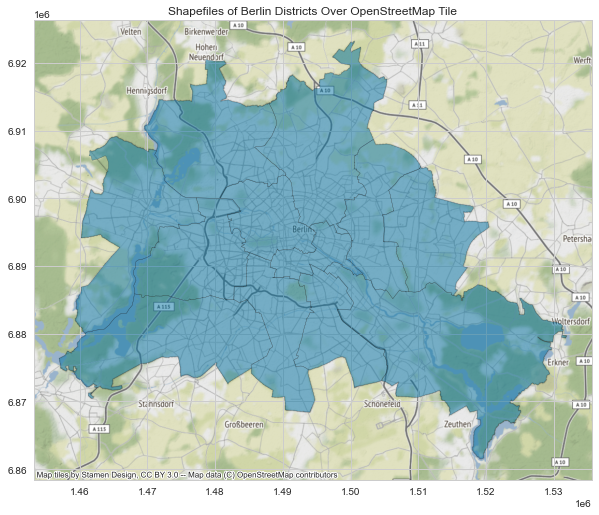

In [113]:
distr_web = distr_gdf1.to_crs(epsg=3857) #converts from UTM to Web Mercator
ax = distr_web.plot(figsize=(10,10), alpha = 0.5, edgecolor='k') #set plot as axis variable (layer)
ctx.add_basemap(ax)
ax.set(title='Shapefiles of Berlin Districts Over OpenStreetMap Tile')

**The 96 Neighborhoods of Berlin**

In [6]:
urlhood = 'https://tsb-opendata.s3.eu-central-1.amazonaws.com/ortsteile/lor_ortsteile.geojson'
hood_gdf = gpd.read_file(urlhood)
hood_gdf = hood_gdf[['spatial_alias', 'BEZIRK','geometry']]
hood_gdf = hood_gdf.rename(columns={'spatial_alias':'Neighborhood Name', 'BEZIRK':'District Name'})
hood_gdf

Neighborhood Name  District Name  \
0                Mitte          Mitte   
1               Moabit          Mitte   
2         Hansaviertel          Mitte   
3           Tiergarten          Mitte   
4              Wedding          Mitte   
..                 ...            ...   
91       Waidmannslust  Reinickendorf   
92              Lübars  Reinickendorf   
93            Wittenau  Reinickendorf   
94  Märkisches Viertel  Reinickendorf   
95         Borsigwalde  Reinickendorf   

                                             geometry  
0   POLYGON ((13.41649 52.52696, 13.41635 52.52702...  
1   POLYGON ((13.33884 52.51974, 13.33884 52.51974...  
2   POLYGON ((13.34322 52.51557, 13.34323 52.51557...  
3   POLYGON ((13.36879 52.49878, 13.36891 52.49877...  
4   POLYGON ((13.34656 52.53879, 13.34664 52.53878...  
..                                                ...  
91  POLYGON ((13.33106 52.61487, 13.33097 52.61479...  
92  POLYGON ((13.36693 52.62535, 13.36692 52.62533...  
93  POLYGON ((13.34413 52.58284, 13.34414 52.58285...  
94  POLYGON ((13.34756 52.59008, 13.34757 52.59009...  
95  POLYGON ((13.31924 52.58739, 13.31938 52.58756...  

[96 rows x 3 columns]

In [7]:
area = []
lats = []
lons = []
name = []

for idx, row in hood_gdf.iterrows():
        name.append(row['Neighborhood Name'])
        polygon = row['geometry']
        p=polygon.representative_point()
        lons.append(p.x)
        lats.append(p.y)
        
        geom_aea = ops.transform(
            pyproj.Proj("epsg:3035"
            ),
        polygon)
        a = geom_aea.area/1000**2
        area.append(a)             

neighborhoods = pd.DataFrame(data={'Neighborhood':name, 'Longitude':lons, 'Latitude':lats, 'Area':area})
neighborhoods.sort_values(['Neighborhood'], ascending=True, axis=0, inplace=True)
neighborhoods.reset_index(drop=True, inplace=True)
neighborhoods

Neighborhood  Longitude   Latitude       Area
0              Adlershof  13.543297  52.437811   6.128075
1   Alt-Hohenschönhausen  13.504253  52.548654   9.352685
2            Alt-Treptow  13.449517  52.489554   2.313942
3           Altglienicke  13.543510  52.410702   7.876913
4         Baumschulenweg  13.467907  52.457860   4.824119
..                   ...        ...        ...        ...
91           Wilhelmsruh  13.364060  52.586678   1.360359
92          Wilhelmstadt  13.192288  52.514834  10.421337
93           Wilmersdorf  13.321453  52.483949   7.160953
94              Wittenau  13.323492  52.592957   5.896168
95            Zehlendorf  13.248874  52.436714  18.801668

[96 rows x 4 columns]

<AxesSubplot:>

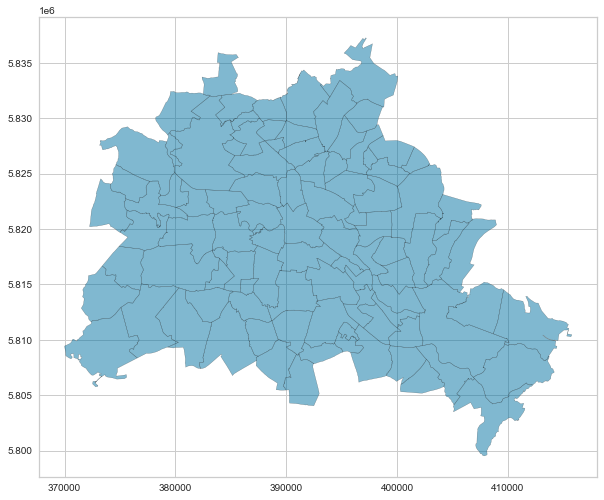

In [8]:
hood_gdf1 = hood_gdf[['Neighborhood Name','geometry']]
hood_utm = hood_gdf1.to_crs(epsg=32633) #converts to UTM Zone 33 coordinates using ESPG code
hood_utm.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

In [116]:
hood_web = hood_gdf1.to_crs(epsg=3857) #converts from UTM to Web Mercator
ax = hood_web.plot(figsize=(10,10), alpha = 0.5, edgecolor='k') # set plot as axis variable
ctx.add_basemap(ax)
ax.set(title='Shapefiles of Berlin Neighborhoods Over OpenStreetMap Tile')

[Text(0.5, 1.0, 'Shapefiles of Berlin Neighborhoods Over OpenStreetMap Tile')]

#### 3.1.2: Demographic Data ####

To give us additional insights into the business environments of each neighborhood or district, the registered residents in Berlin dataset is extracted and processed into a `Pandas` dataframe to find the demographics in the districts and neighborhoods along the characteristic of age.  

**Extracting Resident Data**

In [10]:
# extracting the dataset
url = 'https://www.statistik-berlin-brandenburg.de/opendata/EWR_Ortsteile_2019-12-31.csv'
dem_df_raw = pd.read_csv(url, encoding='latin-1', sep=';', delimiter=';')
dem_df_raw.head()

Bezirk Bez-Name  Ortsteil Ortst-Name  Geschl Staatsangeh Altersgr  \
0       1    Mitte       101      Mitte       1           A    00_05   
1       1    Mitte       101      Mitte       1           A    05_10   
2       1    Mitte       101      Mitte       1           A    10_15   
3       1    Mitte       101      Mitte       1           A    15_20   
4       1    Mitte       101      Mitte       1           A    20_25   

   Häufigkeit  
0         564  
1         435  
2         316  
3         384  
4        1329

In [11]:
# translating columns to English and filtering for columns to be used in this analysis
dem_df_raw.rename(columns = {'Bez-Name': 'District', 'Ortst-Name':'Neighborhood', 'Altersgr': 'AgeGroup', 'Häufigkeit' : 'Population'}, inplace=True)
dem_df_raw = dem_df_raw[['District','Neighborhood','AgeGroup','Population']]
dem_df_raw

District Neighborhood      AgeGroup  Population
0             Mitte        Mitte         00_05         564
1             Mitte        Mitte         05_10         435
2             Mitte        Mitte         10_15         316
3             Mitte        Mitte         15_20         384
4             Mitte        Mitte         20_25        1329
...             ...          ...           ...         ...
7174  Reinickendorf  Borsigwalde         75_80         202
7175  Reinickendorf  Borsigwalde         80_85         126
7176  Reinickendorf  Borsigwalde         85_90          63
7177  Reinickendorf  Borsigwalde         90_95          25
7178  Reinickendorf  Borsigwalde  95 und älter           4

[7179 rows x 4 columns]

**Age Demographics of the 12 Districts of Berlin**

In [12]:
# group and sum age groups according to each district
dem_df_distr = dem_df_raw[['District','Population','AgeGroup']].groupby(['District', 'AgeGroup']).sum().reset_index()
dem_df_distr.head(10)

District AgeGroup  Population
0  Charlottenburg-Wilmersdorf    00_05       13884
1  Charlottenburg-Wilmersdorf    05_10       12350
2  Charlottenburg-Wilmersdorf    10_15       11836
3  Charlottenburg-Wilmersdorf    15_20       12137
4  Charlottenburg-Wilmersdorf    20_25       19321
5  Charlottenburg-Wilmersdorf    25_30       25644
6  Charlottenburg-Wilmersdorf    30_35       27016
7  Charlottenburg-Wilmersdorf    35_40       24120
8  Charlottenburg-Wilmersdorf    40_45       21463
9  Charlottenburg-Wilmersdorf    45_50       21563

In [13]:
# use a pivot table to set age groups as columns
dem_df_distr = pd.pivot_table(dem_df_distr[['District','Population','AgeGroup']], values='Population', index=['District'],columns=['AgeGroup'],aggfunc=np.sum)
dem_df_distr.head()

AgeGroup                    00_05  05_10  10_15  15_20  20_25  25_30  30_35  \
District                                                                      
Charlottenburg-Wilmersdorf  13884  12350  11836  12137  19321  25644  27016   
Friedrichshain-Kreuzberg    15728  12397  10703   9985  16278  30733  38990   
Lichtenberg                 16586  14181  11952  10636  15710  22290  30366   
Marzahn-Hellersdorf         14095  14019  12678  10957  11746  14776  22046   
Mitte                       19759  16471  14988  14753  28208  44257  46153   

AgeGroup                    35_40  40_45  45_50  50_55  55_60  60_65  65_70  \
District                                                                      
Charlottenburg-Wilmersdorf  24120  21463  21563  26021  26147  21550  20964   
Friedrichshain-Kreuzberg    33545  25507  19524  18975  16710  11927   8896   
Lichtenberg                 25448  19087  15596  17783  20352  16847  14746   
Marzahn-Hellersdorf         20511  16304  13578  18438  23721  21181  19018   
Mitte                       35316  27518  23942  24971  23003  17181  13907   

AgeGroup                    70_75  75_80  80_85  85_90  90_95  95 und älter  
District                                                                     
Charlottenburg-Wilmersdorf  18310  18947  12797   5499   2727          1296  
Friedrichshain-Kreuzberg     6147   6354   4487   2274    963           263  
Lichtenberg                 10673  13965  10486   5111   1977           409  
Marzahn-Hellersdorf         11205  11739   8263   3826   1506           360  
Mitte                       10637  10921   8143   3797   1437           386

In [14]:
# aggregate age goups into generational bins more appropriate for this analysis
dem_df_distr['0-15'] = dem_df_distr[dem_df_distr.columns[0:3]].sum(axis = 1)
dem_df_distr['15-30'] = dem_df_distr[dem_df_distr.columns[3:6]].sum(axis = 1)
dem_df_distr['30-50'] = dem_df_distr[dem_df_distr.columns[6:10]].sum(axis = 1)
dem_df_distr['50-65'] = dem_df_distr[dem_df_distr.columns[10:13]].sum(axis = 1)
dem_df_distr['>65'] = dem_df_distr[dem_df_distr.columns[13:20]].sum(axis = 1)
dem_df_distr['Total'] = dem_df_distr[dem_df_distr.columns[1:20]].sum(axis = 1)
dem_df_distr = dem_df_distr[['0-15','15-30','30-50','50-65','>65','Total']]
dem_df_distr

AgeGroup                     0-15  15-30   30-50  50-65    >65   Total
District                                                              
Charlottenburg-Wilmersdorf  38070  57102   94162  73718  80540  329708
Friedrichshain-Kreuzberg    38828  56996  117566  47612  29384  274658
Lichtenberg                 42719  48636   90497  54982  57367  277615
Marzahn-Hellersdorf         40792  37479   72439  63340  55917  255872
Mitte                       51218  87218  132929  65155  49228  365989
Neukölln                    45669  59921  104802  61573  57952  313026
Pankow                      62937  61169  145647  78479  61103  386572
Reinickendorf               37898  44038   64858  56975  62639  253286
Spandau                     36523  41635   62364  51167  53508  232445
Steglitz-Zehlendorf         40427  47779   73858  68163  79844  296978
Tempelhof-Schöneberg        45788  58871   96838  75378  74109  334049
Treptow-Köpenick            37057  40392   79468  56857  59915  259547

Now that we have the age demographic dataframe, we divide the count of each generational bin by the total to understand the relative proportions of each age group for each district.  The `dem_df_distr_rel` dataframe and its neighborhood-level counterpart will prove for our subsequent analysis.  

In [15]:
dem_df_distr_rel = dem_df_distr[['0-15','15-30','30-50','50-65','>65']].div(dem_df_distr['Total'], axis=0).round(2)
dem_df_distr_rel

AgeGroup                    0-15  15-30  30-50  50-65   >65
District                                                   
Charlottenburg-Wilmersdorf  0.12   0.17   0.29   0.22  0.24
Friedrichshain-Kreuzberg    0.14   0.21   0.43   0.17  0.11
Lichtenberg                 0.15   0.18   0.33   0.20  0.21
Marzahn-Hellersdorf         0.16   0.15   0.28   0.25  0.22
Mitte                       0.14   0.24   0.36   0.18  0.13
Neukölln                    0.15   0.19   0.33   0.20  0.19
Pankow                      0.16   0.16   0.38   0.20  0.16
Reinickendorf               0.15   0.17   0.26   0.22  0.25
Spandau                     0.16   0.18   0.27   0.22  0.23
Steglitz-Zehlendorf         0.14   0.16   0.25   0.23  0.27
Tempelhof-Schöneberg        0.14   0.18   0.29   0.23  0.22
Treptow-Köpenick            0.14   0.16   0.31   0.22  0.23

**Age Demographics of the 96 Neighborhoods in Berlin** (same procedure as with districts)

In [16]:
dem_df_hood = dem_df_raw[['Neighborhood','Population','AgeGroup']].groupby(['Neighborhood', 'AgeGroup']).sum().reset_index()
dem_df_hood = pd.pivot_table(dem_df_hood[['Neighborhood','Population','AgeGroup']], values='Population', index=['Neighborhood'],columns=['AgeGroup'],aggfunc=np.sum)
dem_df_hood['0-15'] = dem_df_hood[dem_df_hood.columns[0:3]].sum(axis = 1)
dem_df_hood['15-30'] = dem_df_hood[dem_df_hood.columns[3:6]].sum(axis = 1)
dem_df_hood['30-50'] = dem_df_hood[dem_df_hood.columns[6:10]].sum(axis = 1)
dem_df_hood['50-65'] = dem_df_hood[dem_df_hood.columns[10:13]].sum(axis = 1)
dem_df_hood['>65'] = dem_df_hood[dem_df_hood.columns[13:20]].sum(axis = 1)
dem_df_hood['Total'] = dem_df_hood[dem_df_hood.columns[1:20]].sum(axis = 1)
dem_df_hood = dem_df_hood[['0-15','15-30','30-50','50-65','>65','Total']]
dem_df_hood

AgeGroup                 0-15    15-30    30-50    50-65      >65    Total
Neighborhood                                                              
Adlershof              2642.0   3930.0   6268.0   3597.0   3497.0  18778.0
Alt-Hohenschönhausen   7640.0   7219.0  14199.0   9589.0  10332.0  46128.0
Alt-Treptow            2014.0   1920.0   5450.0   2174.0   1320.0  12067.0
Altglienicke           5051.0   4299.0   8072.0   7010.0   4925.0  27653.0
Baumschulenweg         2170.0   2936.0   5797.0   3490.0   4449.0  17950.0
...                       ...      ...      ...      ...      ...      ...
Wilhelmsruh            1102.0   1100.0   2284.0   1726.0   1795.0   7607.0
Wilhelmstadt           5343.0   6702.0  10251.0   8719.0   9521.0  38720.0
Wilmersdorf           11184.0  16186.0  27784.0  22574.0  24891.0  98597.0
Wittenau               2728.0   3970.0   5481.0   5704.0   6773.0  23684.0
Zehlendorf             7716.0   8449.0  12456.0  13808.0  18109.0  58312.0

[96 rows x 6 columns]

In [17]:
dem_df_hood_rel = dem_df_hood[['0-15','15-30','30-50','50-65','>65']].div(dem_df_hood['Total'], axis=0).round(2)
dem_df_hood_rel

AgeGroup              0-15  15-30  30-50  50-65   >65
Neighborhood                                         
Adlershof             0.14   0.21   0.33   0.19  0.19
Alt-Hohenschönhausen  0.17   0.16   0.31   0.21  0.22
Alt-Treptow           0.17   0.16   0.45   0.18  0.11
Altglienicke          0.18   0.16   0.29   0.25  0.18
Baumschulenweg        0.12   0.16   0.32   0.19  0.25
...                    ...    ...    ...    ...   ...
Wilhelmsruh           0.14   0.14   0.30   0.23  0.24
Wilhelmstadt          0.14   0.17   0.26   0.23  0.25
Wilmersdorf           0.11   0.16   0.28   0.23  0.25
Wittenau              0.12   0.17   0.23   0.24  0.29
Zehlendorf            0.13   0.14   0.21   0.24  0.31

[96 rows x 5 columns]

#### 3.1.3 Foursquare API Venue Data for Districts and Neighborhoods ####

**Conversions between Coordinate Reference Systems (CRSs)** The peculiarities of each CRSs makes different CRSs useful in different situations. The standard latitude/longitude CRS is a geographic CRS, meaning it is referencing points on a globe.  In practice, we deal with geospatial data more often in flat maps, meaning we need a Cartesian CRS to reference points projected onto a flat plane.  UTM is the most widely used Cartesian CRS, making it the more appropriate CRS for our purposes.  Luckily, both PyProj and GeoPandas (which is built on PyProj) makes creating conversion objects from the lat/long CRS to cartesian CRSs simple, only requiring a few lines of code, as shown throughout this section.

#### 3.1.3.a Setting up a Sampling Grid ####

This is a grid of evenly spaced points that allows us to make calls to the Foursquare API throughout the entire city limits of Berlin, this is useful for detailed analysis since the FourSquare API has a limit of returning only 50 venues per point. 

**Finding the Center of Berlin** 
First, we will need to aggregate (or "dissolve") our GeoDataFrame of Berlin's districts to give us a polygon object that is the outer borders of the city-state of Berlin, `berlin_polyg`. Geopandas, a high-level geospatial library built on pyproj, shapely, and others, makes the process of converting from long/lat to UTM xy coordinates quite simple, as shown in creating the `berlin_polyg_utm` object.

State Name
Berlin    POINT (390953.935 5818384.302)
dtype: geometry


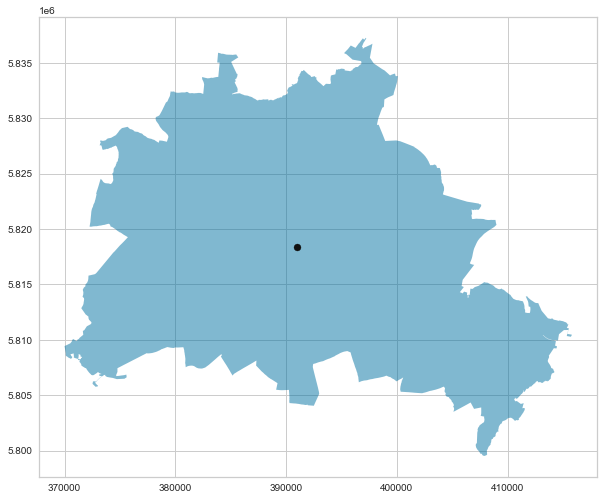

In [18]:
berlin_polyg = distr_gdf.dissolve(by='State Name')
berlin_polyg_utm = berlin_polyg.to_crs(epsg=32633) #converts to UTM Zone 33 coordinates using ESPG code
berlin_rep = berlin_polyg_utm.representative_point()
ax = berlin_rep.plot(figsize=(10,10), color='k', zorder=2)
berlin_polyg_utm.plot(ax=ax, figsize=(10,10), alpha = 0.5, zorder=1)
print(berlin_rep)

State Name
Berlin    POINT (1491437.598 6892364.356)
dtype: geometry


[Text(0.5, 1.0, 'Dissolved (Aggregated) Polygon of Berlin With Central Point')]

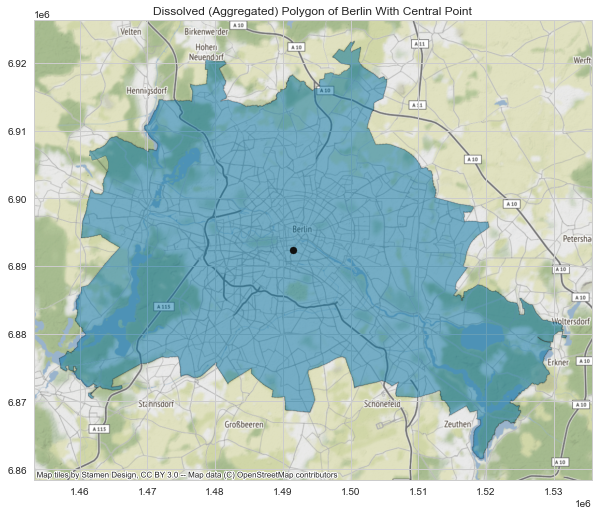

In [119]:
berlin_polyg_web = berlin_polyg.to_crs(epsg=3857)
berlin_rep_web = berlin_polyg_web.representative_point()
ax = berlin_rep_web.plot(figsize=(10,10), color='k', zorder=2)
ax1 = berlin_polyg_web.plot(ax=ax, figsize=(10,10), alpha=0.5, edgecolor='k', zorder=1)
print(berlin_rep_web)
ctx.add_basemap(ax1)
ax.set(title='Dissolved (Aggregated) Polygon of Berlin With Central Point')

GeoDataSeries in Geopandas are a powerful tool for working with large geospatial datasets, but sometimes it can be useful to extract coordinates from the Geodatapoints into a list, or a list of tuples in cases when working with multiple points, as shown with `berlinrepxy`.

In [20]:
berlinrepxy = [[x,y] for x,y in zip(berlin_rep.x, berlin_rep.y)]
berlinrepxy = berlinrepxy[0]
berlinrepxy

[390953.9354498523, 5818384.302123947]

We can create transformer objects using PyProj, one of the primary underlying libraries of GeoPandas, to allow for simple conversion between cartesian (e.g. UTM) and geographic (e.g. lon/lat) CRSs, which can be done using only a few lines of code.  EPSG codes are used for simplicity, but it is possible to use more detailed CRS arguments in the form of a proj string.

In [21]:
trans2xy = pyproj.Transformer.from_crs("epsg:4326","epsg:32633", always_xy=True)
trans2ll = pyproj.Transformer.from_crs("epsg:32633","epsg:4326", always_xy=True)
lon, lat = trans2ll.transform(berlinrepxy[0], berlinrepxy[1])
x, y = trans2xy.transform(lon,lat)
print('Berlin center coordinates in UTM are, X= {}; Y= {}'.format(berlinrepxy[0], berlinrepxy[1]))
print('Berlin center transform to Longitude & Latitude, Lon= {}; Lat= {}'.format(lon,lat))
print('Berlin center reverse transform, X= {}; Y= {}'.format(x, y))

Berlin center coordinates in UTM are, X= 390953.9354498523; Y= 5818384.302123947
Berlin center transform to Longitude & Latitude, Lon= 13.3933946320927; Lat= 52.50466732795851
Berlin center reverse transform, X= 390953.93544985226; Y= 5818384.302123947


**Determining Appropriate Size of Sampling Grid:** Our sampling grid should cover the entire area of Berlin, so to do this we will look at the bounds of our Berlin polygon that has been transformed into UTM Zone 33 North from before.  Through dividing the length of Berlin's range along each axis and dividing it in half, we get the appropriate distances from our center point along each axis to define in the sampling grid.

In [22]:
minx = berlin_polyg_utm.bounds.iloc[0,0]
maxx = berlin_polyg_utm.bounds.iloc[0,2]
miny = berlin_polyg_utm.bounds.iloc[0,1]
maxy = berlin_polyg_utm.bounds.iloc[0,3]
print("Min X = {}\nMax X = {}\nMin Y = {}\nMax Y = {}".format(minx ,maxx ,miny, maxy))
berlin_x_range = maxx - minx
berlin_y_range = maxy - miny
print("The length of Berlin's X range is {} meters and Y range is {} meters.".format(
    berlin_x_range, berlin_y_range))
berlin_x_radius = berlin_x_range/2
berlin_y_radius = berlin_y_range/2
print("The sampling grid should be {} meters from the center along the X axis\nand {} meters from the center along the Y axis."
      .format(berlin_x_radius, berlin_y_radius))

Min X = 370000.82600134326
Max X = 415786.55400086974
Min Y = 5799520.662123909
Max Y = 5837259.270123978
The length of Berlin's X range is 45785.72799952648 meters and Y range is 37738.608000068925 meters.
The sampling grid should be 22892.86399976324 meters from the center along the X axis
and 18869.304000034463 meters from the center along the Y axis.


**Creating the Sampling Grid:** Now the grid is set up for use within the UTM CRS, with 1km spacing between points, the grid is culled to ensure we remain within Berlin's city-state boundaries.

In [23]:
# set sampling grid with points at 1 km intervals
XX = np.arange(-22.89286,22.89286,1)*1000 + berlinrepxy[0]
YY = np.arange(-18.86930,18.86930,1)*1000 + berlinrepxy[1]

In [24]:
# convert points to lon/lat to enable calls to foursquare api
Lats = []
Lons = []

for y in YY:
    for x in XX:
        lon, lat =trans2ll.transform(x,y)
        Lats.append(lat)
        Lons.append(lon)

In [25]:
# create sampling grid in form of dataframe
sample_grid_df = pd.DataFrame(columns = ['Longitude', 'Latitude', 'District'])

# cull sampling grid to ensure points are within Berlin's boundaries
for lon, lat in zip(Lons, Lats):
    point = Point(lon, lat)
    for idx, row in distr_gdf.iterrows():
        polygon = row['geometry']
        #print(row['District Name'])
        if polygon.contains(point):
            #print(row['District Name'])
            sample_grid_df = sample_grid_df.append({'Longitude':lon, 'Latitude':lat, 'District':row['District Name']
                                                   }, ignore_index=True)

sample_grid_df.shape

(884, 3)

In [26]:
# create an identical grid with neighborhoods rather than districts to support later analysis
sample_grid_hood = pd.DataFrame(columns = ['Longitude', 'Latitude', 'Neighborhood'])

for lon, lat in zip(Lons, Lats):
    point = Point(lon, lat)
    for idx, row in hood_gdf.iterrows():
        polygon = row['geometry']
        if polygon.contains(point):
            sample_grid_hood = sample_grid_hood.append({'Longitude':lon, 'Latitude':lat, 'Neighborhood':row['Neighborhood Name']
                                  }, ignore_index=True)
sample_grid_hood.head()

Longitude   Latitude Neighborhood
0  13.650270  52.347215  Schmöckwitz
1  13.649997  52.356203  Schmöckwitz
2  13.649723  52.365191  Schmöckwitz
3  13.664405  52.365357  Schmöckwitz
4  13.649448  52.374178  Schmöckwitz

In [27]:
# merge the district and neighborhood grids to produce final sampling grid use in call to the Foursquare API
sample_grid_df = pd.merge(sample_grid_df, sample_grid_hood, how='outer', on=['Longitude','Latitude'])
sample_grid_df = sample_grid_df.sort_values(['District','Neighborhood']).reset_index(drop=True)
sample_grid_df.head()

Longitude   Latitude                    District    Neighborhood
0  13.291842  52.504420  Charlottenburg-Wilmersdorf  Charlottenburg
1  13.306569  52.504632  Charlottenburg-Wilmersdorf  Charlottenburg
2  13.321295  52.504841  Charlottenburg-Wilmersdorf  Charlottenburg
3  13.336022  52.505049  Charlottenburg-Wilmersdorf  Charlottenburg
4  13.291494  52.513406  Charlottenburg-Wilmersdorf  Charlottenburg

#### 3.1.3b Making Calls to the Foursquare API to Extract Venue Data ####
Read in Foursquare API credentials

In [28]:
# FourSquare credentials read from file on local device to protect private information
KEY = pd.read_csv('~/Projects/IBMCertDS/foursquare_cred.csv')
# define FourSquare credentials and version
CLIENT_ID = KEY.iloc[0,0] 
CLIENT_SECRET = KEY.iloc[0,1] 
VERSION = '20180605' 
LIMIT = 200 

Define the `getNearbyVenues` function that compiles relevant venue data into a dataframe

In [29]:
# define function that will compile relevant venue data into a dataframe
def getNearbyVenues(dists, hoods, latitudes, longitudes, radius):
    
    venues_list=[]
    for dist, hood, lat, lng in zip(dists, hoods, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            dist,
            hood,
            lat,
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],   
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                  'Neighborhood',
                  'Grid Latitude',
                  'Grid Longitude',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

This function is first applied function to Berlin districts with a radius of 710m is used to ensure entire area is covered, after which duplicates are removed to ensure the returned dataset will be useful for this analysis.  Due to the long execution time, the returned dataset from the initial extraction on 31/12/2020 was filtered for duplicates with a reset index to create the `berlin_venues` dataframe, which was saved to the local device.  Code for both the initial extraction and loading the csv from the local device are shown below.

**Call to Foursquare API**

In [ ]:
# berlin_venues = getNearbyVenues(dists=sample_grid_df['District'],
#                                    hoods=sample_grid_df['Neighborhood'],
#                                    latitudes=sample_grid_df['Latitude'],
#                                    longitudes=sample_grid_df['Longitude'],
#                                    radius=710)

**Drop Duplicates and Reset Index in Extracted Dataset**

In [ ]:
# berlin_venues = berlin_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')
# berlin_venues.reset_index(drop=True, inplace=True)

**Saved extraction from 31/12/2020 at 13:34 to local device**

In [ ]:
# berlin_venues.to_csv(path_or_buf='~/Projects/IBMCertDS/Coursera_Capstone/data/berlin_venues.csv')

**Load saved extraction from local device**

In [30]:
berlin_venues = pd.read_csv(filepath_or_buffer='~/Projects/IBMCertDS/Coursera_Capstone/data/berlin_venues.csv', sep=',',index_col=0)

In [31]:
print(berlin_venues.shape)
berlin_venues.head()

(9703, 8)


District    Neighborhood  Grid Latitude  Grid Longitude  \
0  Charlottenburg-Wilmersdorf  Charlottenburg      52.506989       13.296254   
1  Charlottenburg-Wilmersdorf  Charlottenburg      52.506989       13.296254   
2  Charlottenburg-Wilmersdorf  Charlottenburg      52.506989       13.296254   
3  Charlottenburg-Wilmersdorf  Charlottenburg      52.506989       13.296254   
4  Charlottenburg-Wilmersdorf  Charlottenburg      52.506989       13.296254   

                   Venue  Venue Latitude  Venue Longitude  \
0       Restaurant Mylos       52.506656        13.295862   
1            Engelbecken       52.508681        13.293996   
2               Kim's Ha       52.506770        13.296732   
3  Feines aus Österreich       52.505483        13.296532   
4  Restaurant Bruderherz       52.505409        13.297320   

          Venue Category  
0       Greek Restaurant  
1      German Restaurant  
2  Vietnamese Restaurant  
3      German Restaurant  
4     Italian Restaurant

**Heatmaps** are a great visualization tool, so now that the venue dataset has been extracted a heatmap can be generated quite easily using `Folium`.

In [105]:
b=list(zip(berlin_venues['Venue Latitude'].values,berlin_venues['Venue Longitude'].values))
map_berlin_ven = folium.Map(location=[52.5072, 13.3978], zoom_start=10)

plugins.HeatMap(data= b, radius=13, max_zoom=50).add_to(map_berlin_ven)
        
map_berlin_ven

In our analysis it would be useful to know the total counts of venues found within each district and neighborhood, so we incorporate the columns `dist_counts` and `hood_counts` into their respective dataframes for our analysis.

In [33]:
dist_counts = berlin_venues[['Venue', 'District']].groupby('District').count()
dist_counts = dist_counts.rename(columns={'Venue':'Number of Venues'}) 
dist_counts.head()

Number of Venues
District                                    
Charlottenburg-Wilmersdorf              1114
Friedrichshain-Kreuzberg                1251
Lichtenberg                              526
Marzahn-Hellersdorf                      350
Mitte                                   1757

In [34]:
hood_counts = berlin_venues[['Venue', 'Neighborhood']].groupby('Neighborhood').count()
hood_counts = hood_counts.rename(columns={'Venue':'Number of Venues'})   
hood_counts.head()

Number of Venues
Neighborhood                          
Adlershof                           64
Alt-Hohenschönhausen               108
Alt-Treptow                         66
Altglienicke                        42
Baumschulenweg                      43

### 3.2 Exploratory Data Analysis ###

#### 3.2.1 Bar Charts #### 

These plots great for comparative visualization, providing an overview of the number of venues found within each district and neighborhood.

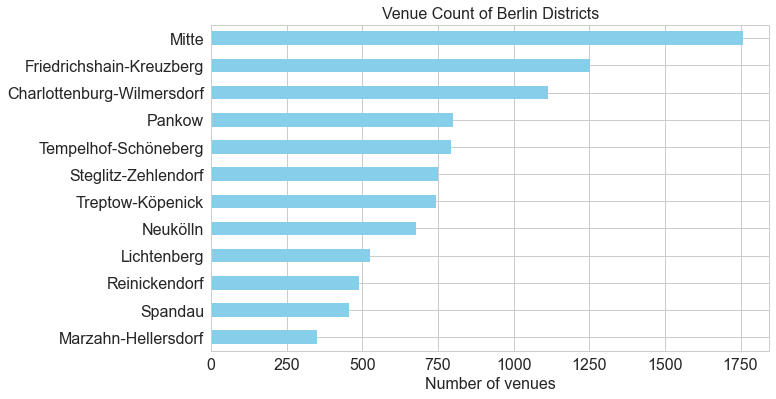

In [169]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10, 6))
dist_counts['Number of Venues'].sort_values().plot(kind = 'barh', fontsize = 16, color = 'skyblue')
plt.ylabel('')
plt.xlabel('Number of venues',  fontsize = 16)
plt.title('Venue Count of Berlin Districts', fontsize=16)
# plt.savefig('~/Projects/IBMCertDS/Coursera_Capstone/report_images/dist_vencount.pdf', bbox_inches='tight', pad_inches = 0.5)

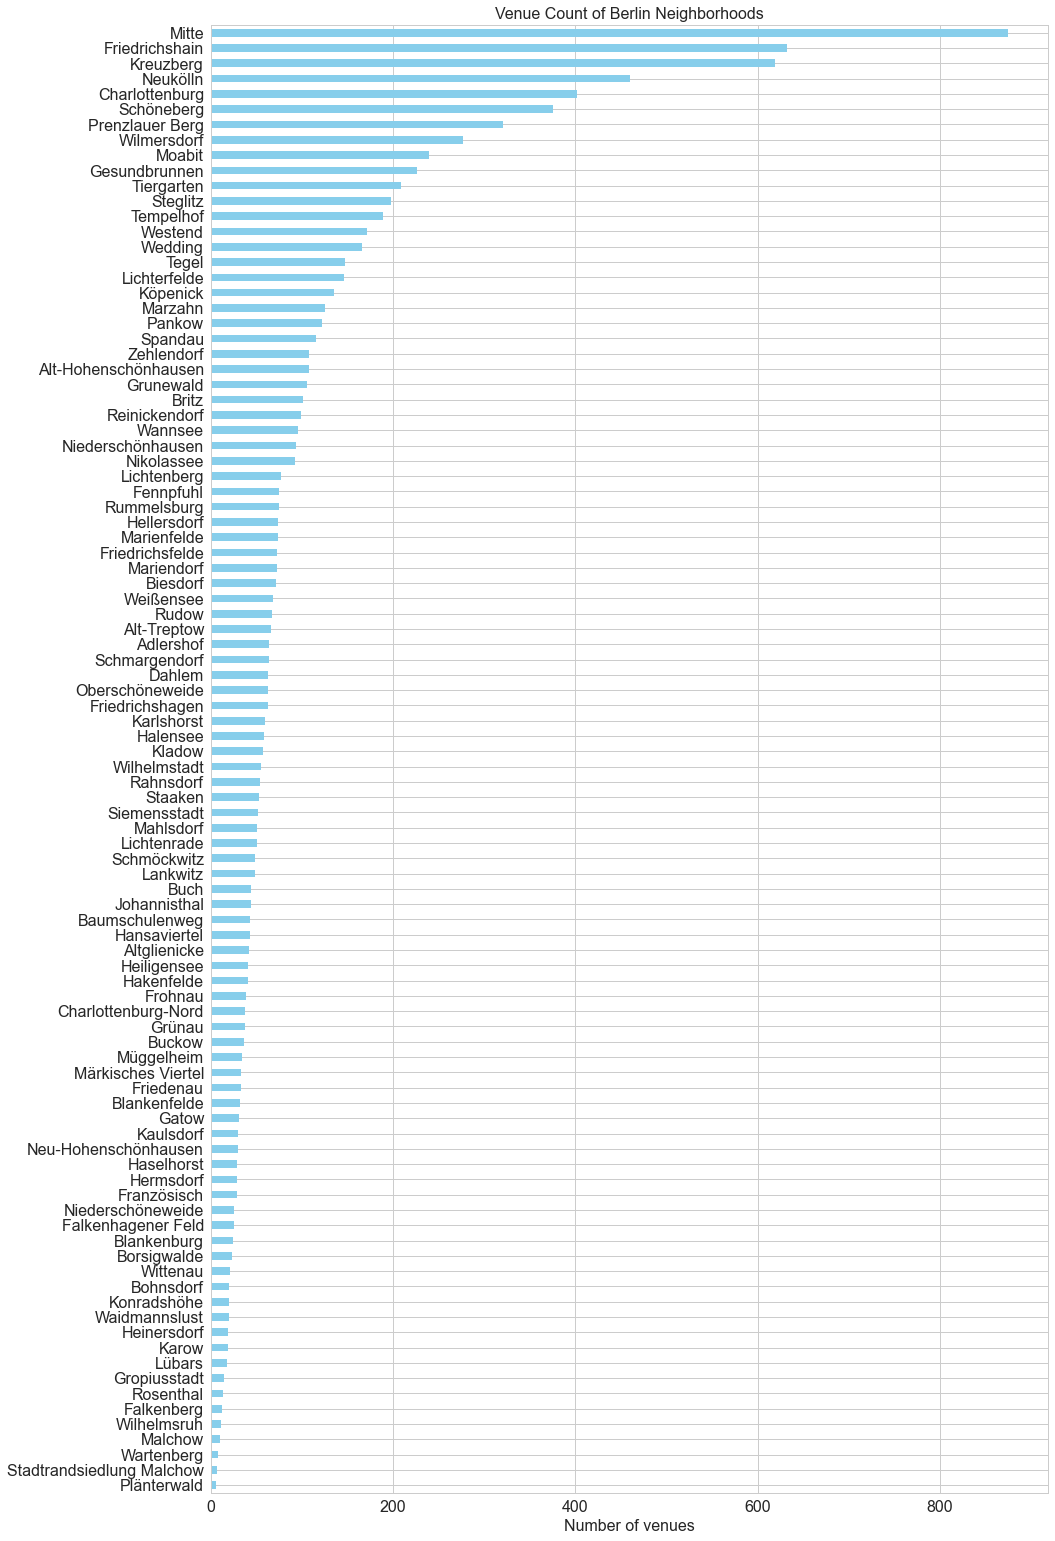

In [173]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (15, 27))
hood_counts['Number of Venues'].sort_values().plot(kind = 'barh', fontsize = 16, color = 'skyblue')
plt.ylabel('')
plt.xlabel('Number of venues',  fontsize = 16)
plt.title('Venue Count of Berlin Neighborhoods', fontsize=16)
# plt.savefig('~Projects/IBMCertDS/Coursera_Capstone/report_images/neighborhood_count.pdf', bbox_inches='tight', pad_inches = 0.5)

Our understanding can be improved through considering the number of venues relative to population, so we create the `VenPerPop` column with the values of venues per 1000 people and create a new bar chart.

In [37]:
disven_df = pd.merge(dem_df_distr, dist_counts, how='outer', on=['District'])
disven_df['VenPerPop'] = disven_df['Number of Venues']/disven_df['Total']*1000
disven_df.head()

0-15  15-30   30-50  50-65    >65   Total  \
District                                                                 
Charlottenburg-Wilmersdorf  38070  57102   94162  73718  80540  329708   
Friedrichshain-Kreuzberg    38828  56996  117566  47612  29384  274658   
Lichtenberg                 42719  48636   90497  54982  57367  277615   
Marzahn-Hellersdorf         40792  37479   72439  63340  55917  255872   
Mitte                       51218  87218  132929  65155  49228  365989   

                            Number of Venues  VenPerPop  
District                                                 
Charlottenburg-Wilmersdorf              1114   3.378747  
Friedrichshain-Kreuzberg                1251   4.554755  
Lichtenberg                              526   1.894710  
Marzahn-Hellersdorf                      350   1.367871  
Mitte                                   1757   4.800691

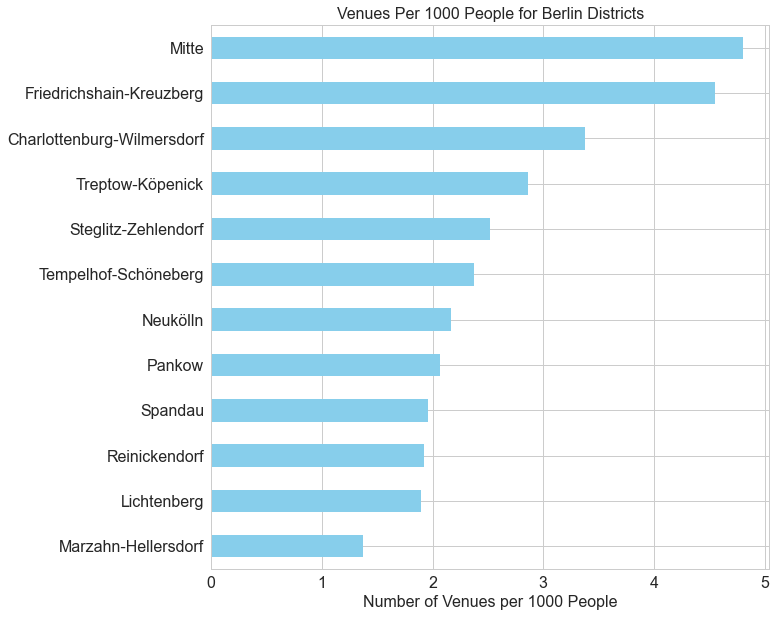

In [168]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10, 10))
disven_df['VenPerPop'].sort_values().plot(kind = 'barh', fontsize = 16, color = 'skyblue')
plt.ylabel('')
plt.xlabel('Number of Venues per 1000 People',  fontsize = 16)
plt.title('Venues Per 1000 People for Berlin Districts', fontsize=16)
# plt.savefig('~/Projects/IBMCertDS/Coursera_Capstone/report_images/venperpop_dist.pdf', bbox_inches='tight', pad_inches = 0.5)

In [39]:
hoodven_df = pd.merge(dem_df_hood, hood_counts, how='outer', on=['Neighborhood'])
hoodven_df['VenPerPop'] = hoodven_df['Number of Venues']/hoodven_df['Total']*1000
hoodven_df.head()

0-15   15-30    30-50   50-65      >65    Total  \
Neighborhood                                                              
Adlershof             2642.0  3930.0   6268.0  3597.0   3497.0  18778.0   
Alt-Hohenschönhausen  7640.0  7219.0  14199.0  9589.0  10332.0  46128.0   
Alt-Treptow           2014.0  1920.0   5450.0  2174.0   1320.0  12067.0   
Altglienicke          5051.0  4299.0   8072.0  7010.0   4925.0  27653.0   
Baumschulenweg        2170.0  2936.0   5797.0  3490.0   4449.0  17950.0   

                      Number of Venues  VenPerPop  
Neighborhood                                       
Adlershof                         64.0   3.408244  
Alt-Hohenschönhausen             108.0   2.341311  
Alt-Treptow                       66.0   5.469462  
Altglienicke                      42.0   1.518823  
Baumschulenweg                    43.0   2.395543

When inspecting the `hoodven_df` dataframe, it becomes clear there is some there are some **missing values** for two neighborhoods, so we will replace these with the mean to prevent them from influencing our subsequent analysis

In [40]:
hoodven_df['VenPerPop'] = hoodven_df['VenPerPop'].fillna(hoodven_df['VenPerPop'].mean())
hoodven_df['Number of Venues'] = hoodven_df['Number of Venues'].fillna(hoodven_df['Number of Venues'].mean())

**NOTE:** When plotting a horizontal bar chart at the neighborhood level we see some strange results, as the peripheral and less populated areas Malchow and Blankenfelde top the list in terms of venues per 1000 people, but upon closer inspection it is clear this is due to the total population of these neighborhood being 607 and 1998 residents, respectively. Areas such as these have a lot to offer Berlin's residents in terms of outdoor activities, thus resulting in the high number of venues relative to their population.

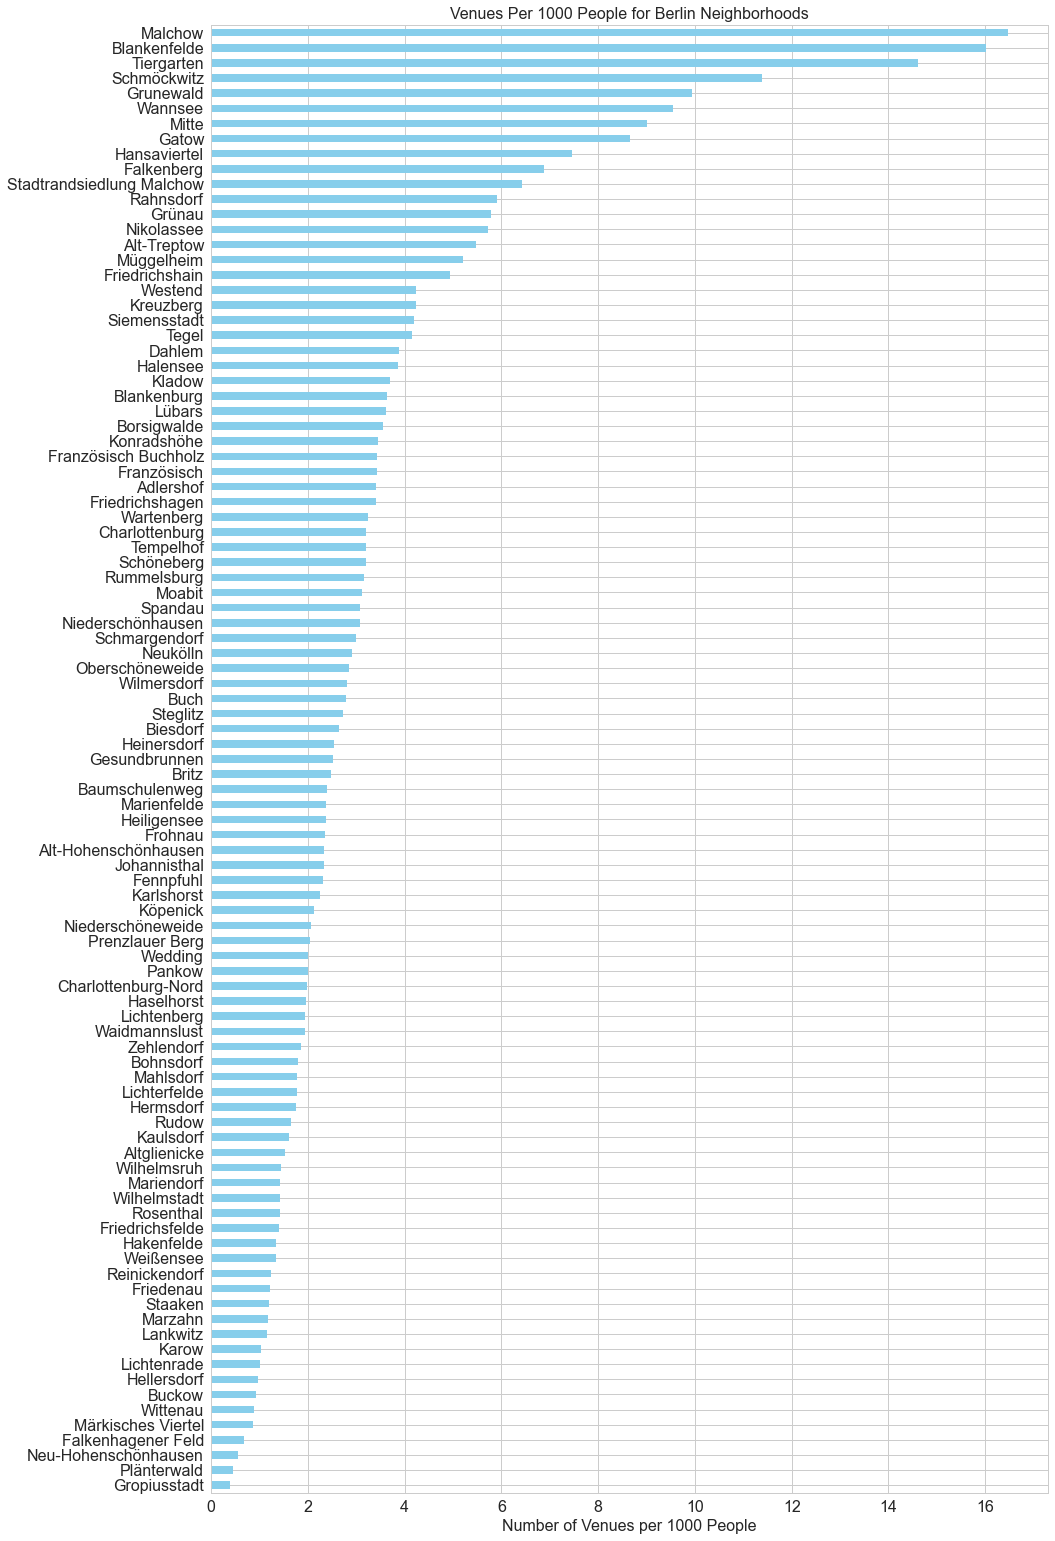

In [172]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,27))
hoodven_df['VenPerPop'].sort_values().plot(kind = 'barh', fontsize = 16, color = 'skyblue')
plt.ylabel('')
plt.xlabel('Number of Venues per 1000 People',  fontsize = 16)
plt.title('Venues Per 1000 People for Berlin Neighborhoods', fontsize=16)
# plt.savefig('~/Projects/IBMCertDS/Coursera_Capstone/report_images/neighborhood_venperpop.pdf', bbox_inches='tight', pad_inches = 0.5)

**Insights from Bar Charts:** Through comparing our bar charts for venues per 1000 people at the district and neighborhood levels, the results are mostly in line with our expectations in that central areas have more venues relative to their population, but at the neighborhood level we see that certain neighborhoods with low populations may have more venues due to their popularity due to certain unique characteristics such as natural landscapes in close proximity to the city.

#### 3.2.2 Regression Plots ####

These plots will help us observe potential correlations between two variables.  Using regression plots we can regress `VenPerPop` against selected age demographic bins, which will give us some insight as to how relative age of local populations may affect the number of venues.

This is done by first combining our VenPerPop columns with our `dem_df_distr_rel` and `dem_df_hood_rel` we can easily create regression plots using `seaborn` and `matplotlib`.

In [42]:
dem_df_distr_rel = dem_df_distr_rel.merge(disven_df[['VenPerPop','Number of Venues']], how = 'left', left_index=True, right_index=True)

In [43]:
dem_df_distr_rel.head()

0-15  15-30  30-50  50-65   >65  VenPerPop  \
District                                                                 
Charlottenburg-Wilmersdorf  0.12   0.17   0.29   0.22  0.24   3.378747   
Friedrichshain-Kreuzberg    0.14   0.21   0.43   0.17  0.11   4.554755   
Lichtenberg                 0.15   0.18   0.33   0.20  0.21   1.894710   
Marzahn-Hellersdorf         0.16   0.15   0.28   0.25  0.22   1.367871   
Mitte                       0.14   0.24   0.36   0.18  0.13   4.800691   

                            Number of Venues  
District                                      
Charlottenburg-Wilmersdorf              1114  
Friedrichshain-Kreuzberg                1251  
Lichtenberg                              526  
Marzahn-Hellersdorf                      350  
Mitte                                   1757

In [44]:
dem_df_hood_rel = dem_df_hood_rel.merge(hoodven_df[['VenPerPop','Number of Venues']], how = 'left', left_index=True, right_index=True)

In [45]:
dem_df_hood_rel.head()

0-15  15-30  30-50  50-65   >65  VenPerPop  \
Neighborhood                                                       
Adlershof             0.14   0.21   0.33   0.19  0.19   3.408244   
Alt-Hohenschönhausen  0.17   0.16   0.31   0.21  0.22   2.341311   
Alt-Treptow           0.17   0.16   0.45   0.18  0.11   5.469462   
Altglienicke          0.18   0.16   0.29   0.25  0.18   1.518823   
Baumschulenweg        0.12   0.16   0.32   0.19  0.25   2.395543   

                      Number of Venues  
Neighborhood                            
Adlershof                         64.0  
Alt-Hohenschönhausen             108.0  
Alt-Treptow                       66.0  
Altglienicke                      42.0  
Baumschulenweg                    43.0

**Normalizing Data:** It is important to note that our age demographics data have been transformed to be their relative share to the total, where the  sum of the age bins in each row is 1.  Our `VenPerPop` and `Number of Venues` columns have ranges much larger than 1, so in order to produce useful regressions, we must make sure all data is at similar scales to ensure we are making a meaningful comparison.  To do this, we will use `sklearn`'s `MinMaxScaler` on both columns, which scales all values on a range of zero (the minimum value) to 1 (the maximum value), a process called *data normalization*.  Therefore, our regressions will use the normalized `dist_rel_norm` and `hood_rel_norm` dataframes.

In [46]:
# normalize total venue count to match 0 to 1 range of population share data
dist_rel_norm = dem_df_distr_rel.copy()
dist_rel_norm[['VenPerPop','Number of Venues']] = preprocessing.MinMaxScaler().fit_transform(dist_rel_norm[['VenPerPop','Number of Venues']])
dist_rel_norm.head()

0-15  15-30  30-50  50-65   >65  VenPerPop  \
District                                                                 
Charlottenburg-Wilmersdorf  0.12   0.17   0.29   0.22  0.24   0.585780   
Friedrichshain-Kreuzberg    0.14   0.21   0.43   0.17  0.11   0.928358   
Lichtenberg                 0.15   0.18   0.33   0.20  0.21   0.153471   
Marzahn-Hellersdorf         0.16   0.15   0.28   0.25  0.22   0.000000   
Mitte                       0.14   0.24   0.36   0.18  0.13   1.000000   

                            Number of Venues  
District                                      
Charlottenburg-Wilmersdorf          0.542999  
Friedrichshain-Kreuzberg            0.640370  
Lichtenberg                         0.125089  
Marzahn-Hellersdorf                 0.000000  
Mitte                               1.000000

In [47]:
# normalize total venue count to match 0 to 1 range of population share data
hood_rel_norm = dem_df_hood_rel.copy()
hood_rel_norm[['VenPerPop','Number of Venues']] = preprocessing.MinMaxScaler().fit_transform(hood_rel_norm[['VenPerPop','Number of Venues']])
hood_rel_norm.head()

0-15  15-30  30-50  50-65   >65  VenPerPop  \
Neighborhood                                                       
Adlershof             0.14   0.21   0.33   0.19  0.19   0.187452   
Alt-Hohenschönhausen  0.17   0.16   0.31   0.21  0.22   0.121103   
Alt-Treptow           0.17   0.16   0.45   0.18  0.11   0.315633   
Altglienicke          0.18   0.16   0.29   0.25  0.18   0.069955   
Baumschulenweg        0.12   0.16   0.32   0.19  0.25   0.124475   

                      Number of Venues  
Neighborhood                            
Adlershof                     0.067816  
Alt-Hohenschönhausen          0.118391  
Alt-Treptow                   0.070115  
Altglienicke                  0.042529  
Baumschulenweg                0.043678

Text(0.5, 0.98, 'Correlations between Share of Age Groups and Venue Count: District Level')

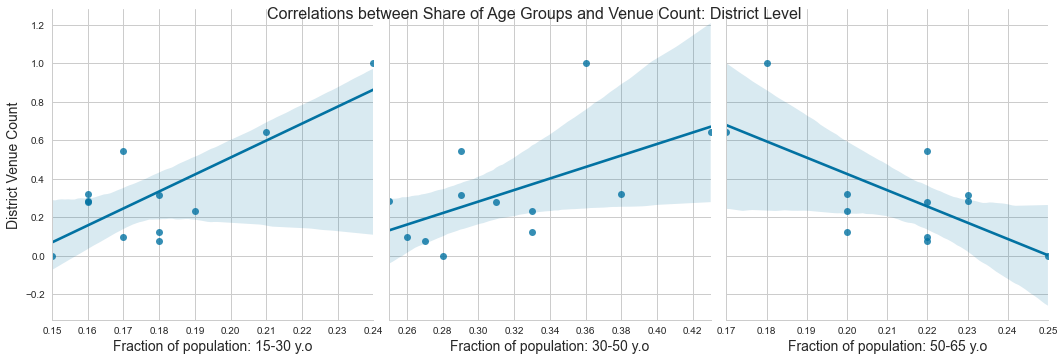

In [144]:
dis_rel_venplot=sns.pairplot(dist_rel_norm, x_vars=["15-30", "30-50", "50-65"], y_vars=["Number of Venues"],
             height=5, kind="reg", diag_kind=None)
dis_rel_venplot.axes[0,0].set_xlabel('Fraction of population: 15-30 y.o', fontsize = 14)
dis_rel_venplot.axes[0,1].set_xlabel('Fraction of population: 30-50 y.o', fontsize = 14)
dis_rel_venplot.axes[0,2].set_xlabel('Fraction of population: 50-65 y.o', fontsize = 14)

dis_rel_venplot.axes[0,0].set_ylabel('District Venue Count', fontsize = 14)
dis_rel_venplot.fig.suptitle('Correlations between Share of Age Groups and Venue Count: District Level', fontsize = 16)

Text(0.5, 0.98, 'Correlations between Share of Age Groups and Venue Count: Neighborhood Level')

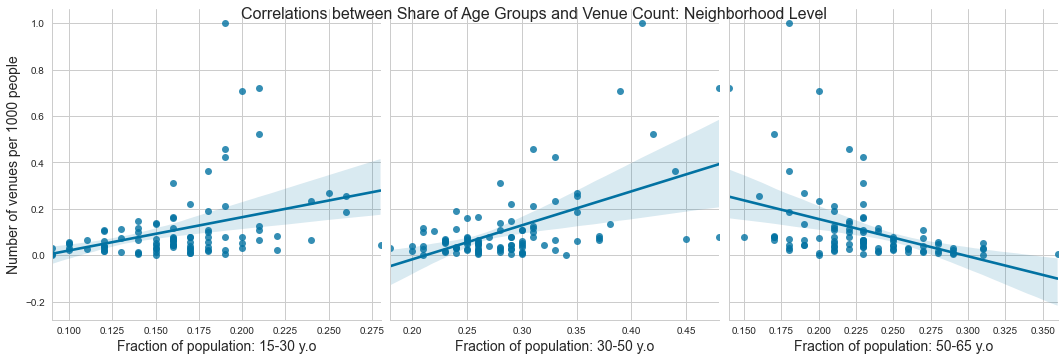

In [146]:
hood_rel_venplot=sns.pairplot(hood_rel_norm, x_vars=["15-30", "30-50", "50-65"], y_vars=["Number of Venues"],
             height=5, kind="reg", diag_kind=None)
hood_rel_venplot.axes[0,0].set_xlabel('Fraction of population: 15-30 y.o', fontsize = 14)
hood_rel_venplot.axes[0,1].set_xlabel('Fraction of population: 30-50 y.o', fontsize = 14)
hood_rel_venplot.axes[0,2].set_xlabel('Fraction of population: 50-65 y.o', fontsize = 14)

hood_rel_venplot.axes[0,0].set_ylabel('Number of venues per 1000 people', fontsize = 14)
hood_rel_venplot.fig.suptitle('Correlations between Share of Age Groups and Venue Count: Neighborhood Level', fontsize = 16)

**Insights from Regression Plots:** We see some correlation between relative age share and number of venues at both the district and neighborhood levels.  The large amount of heteroskedasticity (inconsistent variance) also tells us that while there is a correlation, regression analysis is not suited for estimation or prediction for this relationship without incorporating other explanatory variables.  Such models are beyond the scope of this study, but the key insight here is that relatively younger districts and neighborhoods are ideal locations for opening a new business.  This will prove useful as we interpret results of our cluster analysis below.

### 3.3 Modelling – Cluster Analysis ###

K-Means clustering models are well-suited for our analysis, since they will use the venue data to group districts and neighborhoods into clusters based on their similarity to one another.  This will produce insights into the business environments for each district and neighborhood in Berlin through observing the most popular venues in each cluster.  

#### 3.3.1 Create Datasets to be Used in the Model ####
To begin developing our model, we will first need to transform categorical venue data to numerical values through the *one-hot encoding* method.  After this, we will need to split our encoded dataset into two datasets, one for district-level analysis, and the other for neighborhood-level analysis.

In [50]:
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")
berlin_onehot['District'] = berlin_venues['District'].astype(str)
berlin_onehot['Neighborhood'] = berlin_venues['Neighborhood'].astype(str)
col1 = 'District'
col2 = 'Neighborhood'
first_col = berlin_onehot.pop(col1)
second_col = berlin_onehot.pop(col2)
berlin_onehot.insert(0, col1, first_col)
berlin_onehot.insert(1, col2, second_col)
berlin_onehot.head()

District    Neighborhood  ATM  Accessories Store  \
0  Charlottenburg-Wilmersdorf  Charlottenburg    0                  0   
1  Charlottenburg-Wilmersdorf  Charlottenburg    0                  0   
2  Charlottenburg-Wilmersdorf  Charlottenburg    0                  0   
3  Charlottenburg-Wilmersdorf  Charlottenburg    0                  0   
4  Charlottenburg-Wilmersdorf  Charlottenburg    0                  0   

   Adult Boutique  African Restaurant  American Restaurant  Amphitheater  \
0               0                   0                    0             0   
1               0                   0                    0             0   
2               0                   0                    0             0   
3               0                   0                    0             0   
4               0                   0                    0             0   

   Animal Shelter  Antique Shop  ...  Whisky Bar  Windmill  Wine Bar  \
0               0             0  ...           0         0         0   
1               0             0  ...           0         0         0   
2               0             0  ...           0         0         0   
3               0             0  ...           0         0         0   
4               0             0  ...           0         0         0   

   Wine Shop  Wings Joint  Women's Store  Yemeni Restaurant  Yoga Studio  Zoo  \
0          0            0              0                  0            0    0   
1          0            0              0                  0            0    0   
2          0            0              0                  0            0    0   
3          0            0              0                  0            0    0   
4          0            0              0                  0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 451 columns]

**District-level DataFrame**

In [51]:
districts_onehot = districts.merge(berlin_onehot,how='left', left_on='District', right_on='District')
districts_grouped = districts_onehot.groupby('District').mean().reset_index()
districts_grouped.head()

District  Longitude   Latitude       Area       ATM  \
0  Charlottenburg-Wilmersdorf  13.272751  52.507963  64.692823  0.000898   
1    Friedrichshain-Kreuzberg  13.450698  52.506897  20.399734  0.000799   
2                 Lichtenberg  13.490921  52.532284  52.119980  0.001901   
3         Marzahn-Hellersdorf  13.585397  52.522474  61.817755  0.000000   
4                       Mitte  13.359798  52.533230  39.398803  0.000000   

   Accessories Store  Adult Boutique  African Restaurant  American Restaurant  \
0                0.0        0.000000            0.000000             0.000898   
1                0.0        0.001599            0.003197             0.001599   
2                0.0        0.001901            0.000000             0.000000   
3                0.0        0.000000            0.000000             0.000000   
4                0.0        0.000569            0.000569             0.000569   

   Amphitheater  ...  Whisky Bar  Windmill  Wine Bar  Wine Shop  Wings Joint  \
0      0.000898  ...    0.000898  0.000000  0.000898   0.005386     0.000898   
1      0.000000  ...    0.000799  0.000000  0.005596   0.005596     0.000000   
2      0.000000  ...    0.000000  0.000000  0.000000   0.001901     0.000000   
3      0.000000  ...    0.000000  0.002857  0.000000   0.002857     0.000000   
4      0.000000  ...    0.000569  0.000000  0.005122   0.002277     0.000000   

   Women's Store  Yemeni Restaurant  Yoga Studio       Zoo  Zoo Exhibit  
0       0.000898           0.000000     0.000898  0.000000     0.000898  
1       0.000000           0.000000     0.007194  0.000000     0.000799  
2       0.000000           0.000000     0.001901  0.001901     0.015209  
3       0.000000           0.000000     0.000000  0.000000     0.000000  
4       0.000000           0.000569     0.002277  0.000569     0.009106  

[5 rows x 453 columns]

**Neighborhood-Level DataFrame**

In [52]:
neighborhoods_onehot = neighborhoods.merge(berlin_onehot,how='left', left_on='Neighborhood', right_on='Neighborhood')
neighborhoods_grouped = neighborhoods_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_grouped.head()

Neighborhood  Longitude   Latitude      Area  ATM  \
0             Adlershof  13.543297  52.437811  6.128075  0.0   
1  Alt-Hohenschönhausen  13.504253  52.548654  9.352685  0.0   
2           Alt-Treptow  13.449517  52.489554  2.313942  0.0   
3          Altglienicke  13.543510  52.410702  7.876913  0.0   
4        Baumschulenweg  13.467907  52.457860  4.824119  0.0   

   Accessories Store  Adult Boutique  African Restaurant  American Restaurant  \
0                0.0             0.0                 0.0                  0.0   
1                0.0             0.0                 0.0                  0.0   
2                0.0             0.0                 0.0                  0.0   
3                0.0             0.0                 0.0                  0.0   
4                0.0             0.0                 0.0                  0.0   

   Amphitheater  ...  Whisky Bar  Windmill  Wine Bar  Wine Shop  Wings Joint  \
0           0.0  ...         0.0       0.0       0.0        0.0          0.0   
1           0.0  ...         0.0       0.0       0.0        0.0          0.0   
2           0.0  ...         0.0       0.0       0.0        0.0          0.0   
3           0.0  ...         0.0       0.0       0.0        0.0          0.0   
4           0.0  ...         0.0       0.0       0.0        0.0          0.0   

   Women's Store  Yemeni Restaurant  Yoga Studio  Zoo  Zoo Exhibit  
0            0.0                0.0          0.0  0.0          0.0  
1            0.0                0.0          0.0  0.0          0.0  
2            0.0                0.0          0.0  0.0          0.0  
3            0.0                0.0          0.0  0.0          0.0  
4            0.0                0.0          0.0  0.0          0.0  

[5 rows x 453 columns]

**Create Function That Sorts Most Common Venues in Descending Order – Apply to District and Neighborhood DataFrames**

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
districts_grouped1 = districts_grouped.copy()
districts_grouped1.drop(['Longitude','Latitude','Area'], 1, inplace=True)

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = districts_grouped1['District']

for ind in np.arange(districts_grouped1.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(districts_grouped1.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

District 1st Most Common Venue 2nd Most Common Venue  \
0  Charlottenburg-Wilmersdorf    Italian Restaurant                 Hotel   
1    Friedrichshain-Kreuzberg                  Café                   Bar   
2                 Lichtenberg           Supermarket          Tram Station   
3         Marzahn-Hellersdorf           Supermarket          Tram Station   
4                       Mitte                 Hotel                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Café           Supermarket                Bakery   
1                 Hotel                Bakery           Coffee Shop   
2                Bakery                 Hotel                  Café   
3              Bus Stop                Garden             Drugstore   
4           Coffee Shop    Italian Restaurant           Supermarket   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0     German Restaurant                 Plaza               Bus Stop   
1    Italian Restaurant                  Park  Vietnamese Restaurant   
2             Drugstore              Bus Stop           Soccer Field   
3    Italian Restaurant                 Hotel          Shopping Mall   
4                Bakery                   Bar      German Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0  Vietnamese Restaurant            Coffee Shop  
1         Ice Cream Shop            Supermarket  
2                   Park            Zoo Exhibit  
3         Ice Cream Shop     Light Rail Station  
4             Restaurant                   Park

In [56]:
neighborhoods_grouped1 = neighborhoods_grouped.copy()
neighborhoods_grouped1.drop(['Longitude','Latitude','Area'], 1, inplace=True)

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhood_venues_sorted = pd.DataFrame(columns=columns)
neighborhood_venues_sorted['Neighborhood'] = neighborhoods_grouped1['Neighborhood']

for ind in np.arange(districts_grouped1.shape[0]):
    neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhoods_grouped1.iloc[ind, :], num_top_venues)

neighborhood_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0             Adlershof           Supermarket                  Café   
1  Alt-Hohenschönhausen          Tram Station           Supermarket   
2           Alt-Treptow    Italian Restaurant              Bus Stop   
3          Altglienicke           Supermarket              Bus Stop   
4        Baumschulenweg           Supermarket              Bus Stop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery             Drugstore                 Hotel   
1                 Hotel                  Lake                Bakery   
2                  Café            Restaurant                Bakery   
3                Bakery      Lottery Retailer          Liquor Store   
4                Bakery                  Café                Forest   

  6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
0          Tram Station      Light Rail Station           Gas Station   
1          Soccer Field  Furniture / Home Store             Drugstore   
2           Supermarket        Tapas Restaurant           Coffee Shop   
3    Light Rail Station                   Hotel        Discount Store   
4                  Pier               Drugstore              Platform   

  9th Most Common Venue 10th Most Common Venue  
0                  Park     Italian Restaurant  
1                  Café          Shopping Mall  
2            Playground     Falafel Restaurant  
3                Forest          Bowling Alley  
4          Intersection           Tennis Court

In [59]:
neighborhood_venues_sorted.shape

(96, 11)

#### 3.3.2 Selecting Optimal Number Of Clusters for Model ####
In K-Means Clustering, we need to select the most appropriate value for k to produce meaningful clusters.  While explanatory value always increases *(through a decrease in distortion/error)* with a higher number of clusters, but we must not use too many clusters as this will result in overfitting, where the model is more tuned to the noise within the data than to the underlying relationships.  The **elbow method** is a relatively simple heuristic evaluation method where the model is fitted using a range of values for k, and then plotting each k against its distortion score.  The `yellowbrick` library provides several useful visualization tools for machine learning, and will be used in our Elbow evaluation for our neighborhood and district-level models.

<AxesSubplot:title={'center':'Distortion Score Elbow for District-Level KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

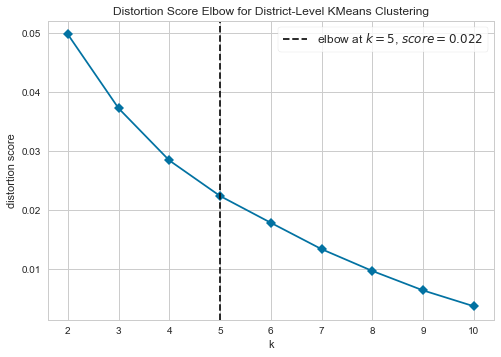

In [157]:
dist_grouped_clustering = districts_grouped.drop(['District', 'Longitude','Latitude','Area'], 1)
model = KMeans(random_state=0)
dist_visualizer = KElbowVisualizer(model, k = (2,11), timings=False, title='Distortion Score Elbow for District-Level KMeans Clustering')
dist_visualizer.fit(dist_grouped_clustering)
dist_visualizer.show(outpath='/Users/eric/Projects/IBMCertDS/Coursera_Capstone/report_images/elbow_dist.pdf')

While it is clear that the **elbow point at k = 5** is a relatively weak one, it is still clear that the decrease in distortion observed with each increase in K is relatively higher before 5 than it is after 5, making 5 the value of k we will use in the application of this model at the district level.

In [156]:
hood_grouped_clustering = neighborhoods_grouped.drop(['Neighborhood', 'Longitude','Latitude','Area'], 1)
model = KMeans(random_state=0)
dist_visualizer = KElbowVisualizer(model, k = (2,12), timings=False, title='Distortion Score Elbow for Neighborhood-Level KMeans Clustering')
dist_visualizer.fit(hood_grouped_clustering)
dist_visualizer.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for Neighborhood-Level KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

This **elbow point at k=7** is also a relatively weak elbow point, but there is still relatively less decrease in distortion beyond it so it will be used in application of this model at the neighborhood level.

#### 3.3.4 Application of District- and Neighborhood-level Models and Results ####

Using the values for k above to set the number of clusters, we apply out district- and neighborhood-level models, observe the most common venues in each model, and visualize our clusters in a Choropleth maps.

#### Applying Refined KMeans-Cluster Models ####

In [62]:
kclusters = 5

dist_grouped_clustering = districts_grouped.drop(['District', 'Longitude','Latitude','Area'], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dist_grouped_clustering)
kmeans.labels_[0:12] 

array([0, 0, 3, 2, 0, 1, 3, 1, 4, 1, 1, 3], dtype=int32)

In [63]:
# add column clustering labels for visualization
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#merge dataframes
districts_merged = districts.join(district_venues_sorted.set_index('District'), on='District')
districts_merged.head()

District  Longitude   Latitude       Area  \
0  Charlottenburg-Wilmersdorf  13.272751  52.507963  64.692823   
1    Friedrichshain-Kreuzberg  13.450698  52.506897  20.399734   
2                 Lichtenberg  13.490921  52.532284  52.119980   
3         Marzahn-Hellersdorf  13.585397  52.522474  61.817755   
4                       Mitte  13.359798  52.533230  39.398803   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0    Italian Restaurant                 Hotel   
1               0                  Café                   Bar   
2               3           Supermarket          Tram Station   
3               2           Supermarket          Tram Station   
4               0                 Hotel                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Café           Supermarket                Bakery   
1                 Hotel                Bakery           Coffee Shop   
2                Bakery                 Hotel                  Café   
3              Bus Stop                Garden             Drugstore   
4           Coffee Shop    Italian Restaurant           Supermarket   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0     German Restaurant                 Plaza               Bus Stop   
1    Italian Restaurant                  Park  Vietnamese Restaurant   
2             Drugstore              Bus Stop           Soccer Field   
3    Italian Restaurant                 Hotel          Shopping Mall   
4                Bakery                   Bar      German Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0  Vietnamese Restaurant            Coffee Shop  
1         Ice Cream Shop            Supermarket  
2                   Park            Zoo Exhibit  
3         Ice Cream Shop     Light Rail Station  
4             Restaurant                   Park

Final result saved to local device

In [68]:
# districts_merged.to_csv(path_or_buf='~/Projects/IBMCertDS/Coursera_Capstone/data/b_district_clusters.csv')

## 4. Exploration and Discussion of KMeans-Cluster Results ##

#### 4.1 Visualizing Clusters in Choropleth Maps ####

This is a useful tool to help communicate the results of our analysis, and with GeoPandas visualizing our clusters is quite simple requiring only a few lines of code once we convert our dataframe to a GeoDataFrame.

In [64]:
dist1 = districts_merged[['District','Longitude','Latitude','Cluster Labels']]
dist_choro = dist1.merge(distr_gdf[['geometry']], how='left', left_index=True, right_index=True)
dist_choro = gpd.GeoDataFrame(dist_choro, geometry=dist_choro['geometry'])
dist_choro = dist_choro.set_crs(epsg=4326, allow_override=True)
dist_choro.head()

District  Longitude   Latitude  Cluster Labels  \
0  Charlottenburg-Wilmersdorf  13.272751  52.507963               0   
1    Friedrichshain-Kreuzberg  13.450698  52.506897               0   
2                 Lichtenberg  13.490921  52.532284               3   
3         Marzahn-Hellersdorf  13.585397  52.522474               2   
4                       Mitte  13.359798  52.533230               0   

                                            geometry  
0  MULTIPOLYGON (((13.32074 52.62660, 13.32045 52...  
1  MULTIPOLYGON (((13.32111 52.52446, 13.32103 52...  
2  MULTIPOLYGON (((13.57925 52.39083, 13.57958 52...  
3  MULTIPOLYGON (((13.50481 52.61960, 13.50467 52...  
4  MULTIPOLYGON (((13.45832 52.48569, 13.45823 52...

[Text(0.5, 1.0, 'District-Level Clusters Over OpenStreetMap Tile')]

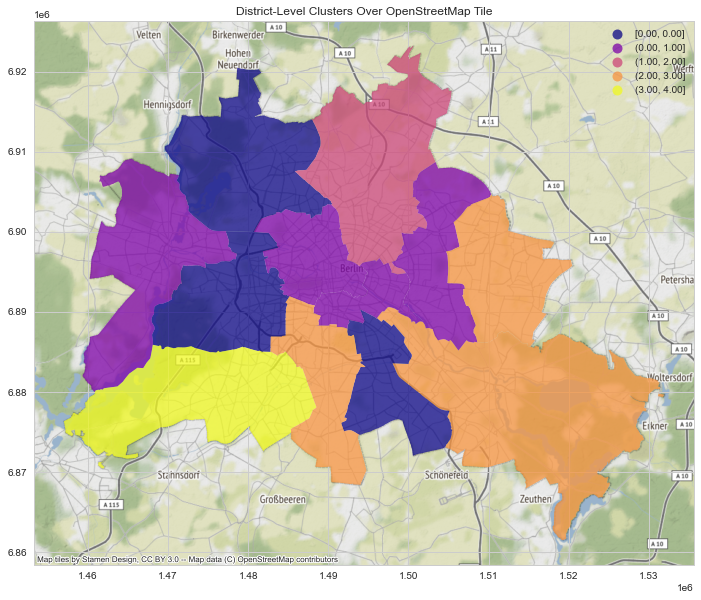

In [159]:
dist_choro_web = dist_choro.to_crs(epsg=3857)
ax = dist_choro_web.plot(column='Cluster Labels', cmap='plasma', figsize=(15,10), scheme='user_defined', 
                         classification_kwds={'bins':[0, 1, 2,3,4]}, alpha=0.75, legend=True)
ctx.add_basemap(ax)
ax.set(title='District-Level Clusters Over OpenStreetMap Tile')

In [66]:
kclusters = 7

hood_grouped_clustering = neighborhoods_grouped.drop(['Neighborhood', 'Longitude','Latitude','Area'], 1)
kmeans1 = KMeans(n_clusters=kclusters, random_state=0).fit(hood_grouped_clustering)
kmeans1.labels_[0:96] 

array([0, 0, 4, 1, 5, 5, 5, 2, 2, 1, 5, 2, 5, 4, 5, 4, 2, 1, 0, 0, 4, 1,
       2, 4, 4, 6, 4, 4, 2, 0, 1, 4, 4, 5, 1, 0, 1, 1, 5, 0, 1, 1, 5, 6,
       4, 0, 1, 0, 5, 5, 2, 0, 2, 5, 5, 0, 4, 4, 5, 2, 1, 4, 4, 0, 2, 0,
       0, 6, 4, 2, 5, 1, 5, 4, 4, 2, 4, 5, 5, 1, 3, 4, 2, 5, 4, 5, 2, 1,
       4, 5, 4, 5, 6, 4, 1, 4], dtype=int32)

In [67]:
# add column clustering labels for visualization
neighborhood_venues_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)

#merge dataframes
neighborhoods_merged = neighborhoods.join(neighborhood_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
neighborhoods_merged.head()

Neighborhood  Longitude   Latitude      Area  Cluster Labels  \
0             Adlershof  13.543297  52.437811  6.128075               0   
1  Alt-Hohenschönhausen  13.504253  52.548654  9.352685               0   
2           Alt-Treptow  13.449517  52.489554  2.313942               4   
3          Altglienicke  13.543510  52.410702  7.876913               1   
4        Baumschulenweg  13.467907  52.457860  4.824119               5   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Supermarket                  Café                Bakery   
1          Tram Station           Supermarket                 Hotel   
2    Italian Restaurant              Bus Stop                  Café   
3           Supermarket              Bus Stop                Bakery   
4           Supermarket              Bus Stop                Bakery   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Drugstore                 Hotel          Tram Station   
1                  Lake                Bakery          Soccer Field   
2            Restaurant                Bakery           Supermarket   
3      Lottery Retailer          Liquor Store    Light Rail Station   
4                  Café                Forest                  Pier   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0      Light Rail Station           Gas Station                  Park   
1  Furniture / Home Store             Drugstore                  Café   
2        Tapas Restaurant           Coffee Shop            Playground   
3                   Hotel        Discount Store                Forest   
4               Drugstore              Platform          Intersection   

  10th Most Common Venue  
0     Italian Restaurant  
1          Shopping Mall  
2     Falafel Restaurant  
3          Bowling Alley  
4           Tennis Court

Final result saved to local device

In [69]:
# neighborhoods_merged.to_csv(path_or_buf='~/Projects/IBMCertDS/Coursera_Capstone/data/b_neighborhood_clusters.csv')

In [68]:
hood1 = neighborhoods_merged[['Neighborhood','Longitude','Latitude','Cluster Labels']]
hood_choro = hood1.merge(hood_gdf[['geometry']], how='left', left_index=True, right_index=True)
hood_choro = gpd.GeoDataFrame(hood_choro, geometry=hood_choro['geometry'])
hood_choro = hood_choro.set_crs(epsg=4326, allow_override=True)
hood_choro.head()

Neighborhood  Longitude   Latitude  Cluster Labels  \
0             Adlershof  13.543297  52.437811               0   
1  Alt-Hohenschönhausen  13.504253  52.548654               0   
2           Alt-Treptow  13.449517  52.489554               4   
3          Altglienicke  13.543510  52.410702               1   
4        Baumschulenweg  13.467907  52.457860               5   

                                            geometry  
0  POLYGON ((13.41649 52.52696, 13.41635 52.52702...  
1  POLYGON ((13.33884 52.51974, 13.33884 52.51974...  
2  POLYGON ((13.34322 52.51557, 13.34323 52.51557...  
3  POLYGON ((13.36879 52.49878, 13.36891 52.49877...  
4  POLYGON ((13.34656 52.53879, 13.34664 52.53878...

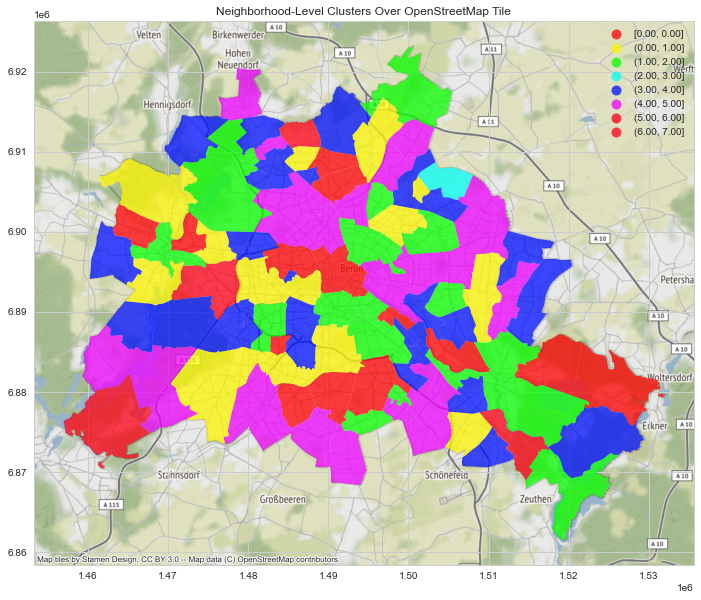

In [170]:
hood_choro_web = hood_choro.to_crs(epsg=3857)
ax = hood_choro_web.plot(column='Cluster Labels', cmap='hsv', figsize=(15,10), scheme='user_defined', 
                         classification_kwds={'bins':[0, 1, 2,3,4,5,6,7]}, alpha=0.75, legend=True)
ctx.add_basemap(ax)
ax.set(title='Neighborhood-Level Clusters Over OpenStreetMap Tile')
# ax.figure.savefig('~/Projects/IBMCertDS/Coursera_Capstone/report_images/neighborhood_clusters.pdf')

#### 4.2 Selected District-Level Clusters ####

**District Cluster One:** Central Affluent Districts

In [175]:
districts_merged[districts_merged['Cluster Labels']==0].head(3)

District  Longitude   Latitude       Area  \
0  Charlottenburg-Wilmersdorf  13.272751  52.507963  64.692823   
1    Friedrichshain-Kreuzberg  13.450698  52.506897  20.399734   
4                       Mitte  13.359798  52.533230  39.398803   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0    Italian Restaurant                 Hotel   
1               0                  Café                   Bar   
4               0                 Hotel                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Café           Supermarket                Bakery   
1                 Hotel                Bakery           Coffee Shop   
4           Coffee Shop    Italian Restaurant           Supermarket   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0     German Restaurant                 Plaza               Bus Stop   
1    Italian Restaurant                  Park  Vietnamese Restaurant   
4                Bakery                   Bar      German Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0  Vietnamese Restaurant            Coffee Shop  
1         Ice Cream Shop            Supermarket  
4             Restaurant                   Park

This cluster represents the most central and affluent neighborhoods in Berlin.  We can see the most common venue types are hotels, restaurants, cafes and bakeries, reflecting the numerous attractions and higher levels of disposable income in these districts.

**District Cluster Two:** Peripheral Districts

In [71]:
districts_merged[districts_merged['Cluster Labels']==3].head(3)

District  Longitude   Latitude        Area  Cluster Labels  \
2        Lichtenberg  13.490921  52.532284   52.119980               3   
6             Pankow  13.436379  52.597658  103.216361               3   
11  Treptow-Köpenick  13.626335  52.417898  167.734542               3   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
2            Supermarket          Tram Station                Bakery   
6            Supermarket                  Café                Bakery   
11           Supermarket          Tram Station                  Café   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
2                  Hotel                  Café             Drugstore   
6           Tram Station              Bus Stop                  Park   
11              Bus Stop                Bakery                  Lake   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
2               Bus Stop          Soccer Field                  Park   
6     Italian Restaurant             Drugstore     German Restaurant   
11     German Restaurant                 Hotel                  Park   

   10th Most Common Venue  
2             Zoo Exhibit  
6             Coffee Shop  
11                  Beach

For contrast, we see that in the peripheral district supermarkets and tram stations top the ranking, implying that the areas are more residential with residents commuting to the city.

#### 4.3 Selected Neighborhood-Level Clusters ####

***Issue of Scarce Data*** While it was still possible to group clusters at the neighborhood level, the dependence of the Foursquare Places API data on user input has caused an issue of data scarcity, with some neighborhoods having less than 10 individual venue categories within them.  This caused some clusters to not provide as much insight as was initially hoped for, but some clusters still provide useful insights into their respective business environments.

**Cluster 6:** Residential Consumer Preferences

In [72]:
neighborhoods_merged[neighborhoods_merged['Cluster Labels']==5].head(3)

Neighborhood  Longitude   Latitude       Area  Cluster Labels  \
4  Baumschulenweg  13.467907  52.457860   4.824119               5   
5        Biesdorf  13.557604  52.504237  12.442222               5   
6     Blankenburg  13.461722  52.594035   6.061649               5   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
4           Supermarket              Bus Stop                Bakery   
5           Supermarket              Bus Stop                  Lake   
6              Bus Stop           Supermarket                Garden   

        4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
4                        Café                Forest                  Pier   
5          Italian Restaurant        Ice Cream Shop             Drugstore   
6  Construction & Landscaping            Restaurant      Greek Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
4             Drugstore              Platform          Intersection   
5             Pet Store         Metro Station     Electronics Store   
6         Train Station           Golf Course                  Tree   

  10th Most Common Venue  
4           Tennis Court  
5          Shopping Mall  
6                 Bakery

We see the added benefits of observation at the neighborhood level, as we see more specific common venues in these residential districts such as pet stores, gardens, drugstores, and shopping malls along with the generally common venues such as supermarkets and bus stops.

## 5. Concluding Remarks ##

#### 5.1 Conclusions on Cluster Analysis ####

This project allowed for exploration of powerful Python libraries in the areas of geospatial data manipulation and visualization, statistics, and machine learning.  Through applying these libraries on available data for cities such as Berlin, it is clear that useful insights into local environments can be generated.  Despite issues cause by data scarcity, some generalizations about business environments could be made at the district and neighborhood levels.

**Tourism/Gastronomy/Nightlife** businesses oriented to these sectors are best suited in the clusters representing more central and affluent districts, as these sectors are generally more active in these areas.

**Retail/Grocery/Family Needs** are more suited to peripheral and residential areas, as there is more activity in these areas.

These conclusions are highly generalized due to the general nature of this project's question, but the data and visualizations generated in this assignment can be used to provide tailored advice to entrepreneurs with a specific business idea in mind. 

#### 5.2 Future Improvements on the Model ####

The weak elbow points in the district- and neighborhood-level models indicate room for improvement in the model.  There are a number of possible pathways to improving the model, a few thoughts are listed below:

1. Incorporate additional demographic data, for sake of simplicity the clustering algorithm was only run on the venue data.  It is possible that including age demographic data along with other variables such as income, education, family size, etc.  Prioritized future iterations will incorporate age data and perhaps income data, to confirm initial conclusions on the relationship between income level and spending patterns stated in the previous section.
2. Use a different clustering model, such as the density-based DBSCAN algorithm.  Multiple algorithms can be applied and evaluated in terms of performance side-by-side.

Results of efforts to improve the model will be updated in this GitHub repository and in future reports.
